# ⏰ Time Travel Demo - Apache Iceberg

## Credit Card Fraud Detection - IEEE-CIS Dataset

**Yêu cầu đề bài:** 
> "Yêu cầu tính năng Time Travel của Iceberg để truy vấn lại trạng thái dữ liệu tại thời điểm quá khứ nhằm kiểm tra lại các giao dịch nghi vấn."

**Mục tiêu:**
- Demo tính năng Time Travel của Apache Iceberg
- Truy vấn dữ liệu tại các snapshot khác nhau
- Kiểm tra lại trạng thái giao dịch nghi vấn tại thời điểm quá khứ
- Rollback dữ liệu về version trước nếu cần

---
### ⚠️ Lưu ý quan trọng

**Notebook này hoạt động SAU KHI đã chạy pipeline đầy đủ:**
- Nếu chạy từ **Script Full**: `./scripts/run_full_pipeline.sh` → Notebook sẽ sử dụng bảng `demo.bronze_silver.silver_transactions`
- Nếu chạy từ **Notebooks 1-4**: Chạy lần lượt 01 → 02 → 03 → 04 trước khi chạy notebook này

**Tên bảng và cột (từ dbt):**
- Bảng: `demo.bronze_silver.silver_transactions`
- Các cột: `is_fraud`, `transaction_amount`, `risk_score`, `TransactionID`

## 1. Khởi tạo Spark Session

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from datetime import datetime

# Khởi tạo Spark Session
spark = SparkSession.builder \
    .appName("Time Travel Demo - Fraud Detection") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.demo", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.demo.type", "rest") \
    .config("spark.sql.catalog.demo.uri", "http://iceberg-rest:8181") \
    .config("spark.sql.catalog.demo.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
    .config("spark.sql.catalog.demo.warehouse", "s3://warehouse/") \
    .config("spark.sql.catalog.demo.s3.endpoint", "http://minio:9000") \
    .config("spark.sql.catalog.demo.s3.path-style-access", "true") \
    .config("spark.sql.catalog.demo.s3.access-key-id", "admin") \
    .config("spark.sql.catalog.demo.s3.secret-access-key", "password123") \
    .config("spark.sql.defaultCatalog", "demo") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "admin") \
    .config("spark.hadoop.fs.s3a.secret.key", "password123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

print("✅ Spark Session đã khởi tạo!")

✅ Spark Session đã khởi tạo!


## 2. Xem lịch sử Snapshots của bảng

Iceberg lưu trữ mỗi thay đổi dữ liệu như một "snapshot". Ta có thể xem lịch sử các snapshots để biết các thời điểm có thể truy vấn.

In [19]:
# Xem lịch sử snapshots của bảng silver_transactions (từ dbt)
# Lưu ý: Khi chạy từ full script, dbt tạo bảng ở schema bronze_silver
TABLE_NAME = "demo.bronze_silver.silver_transactions"

print(f"📜 Lịch sử Snapshots - {TABLE_NAME}:")
print("=" * 80)

df_snapshots = spark.sql(f"""
    SELECT 
        snapshot_id,
        committed_at,
        operation,
        summary
    FROM {TABLE_NAME}.snapshots
    ORDER BY committed_at
""")

df_snapshots.show(truncate=False)

# Lưu snapshot IDs để sử dụng sau
snapshots = df_snapshots.collect()
print(f"\n📊 Tổng số snapshots: {len(snapshots)}")

📜 Lịch sử Snapshots - demo.bronze_silver.silver_transactions:
+-------------------+-----------------------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|snapshot_id        |committed_at           |operation|summary                                                                                                                                                                                                                                                                    

/tmp/ipykernel_3468/1690090275.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


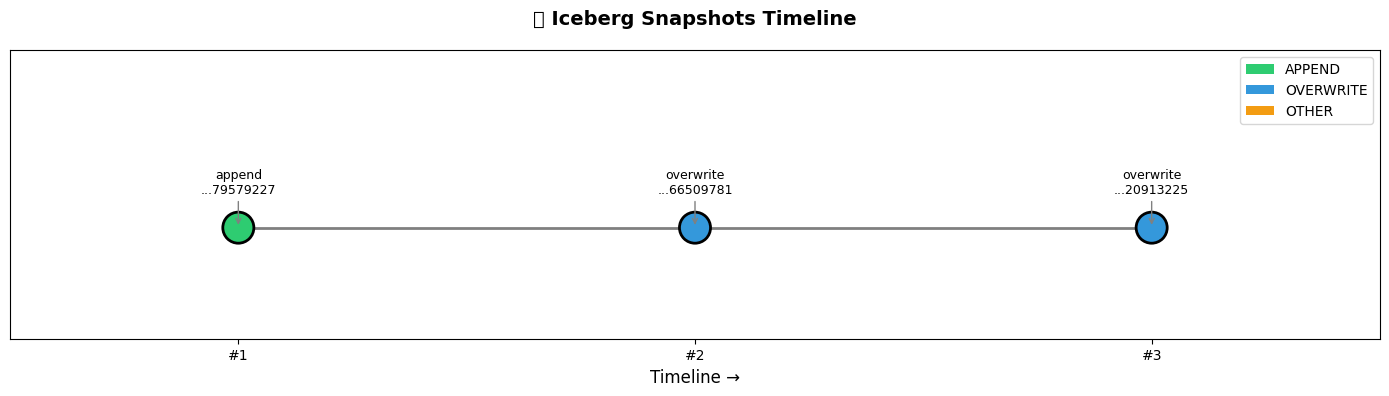

📊 Tổng số snapshots: 3
   Mỗi snapshot cho phép time travel đến thời điểm đó!


In [20]:
# 📊 VISUALIZATION: Snapshot Timeline
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(figsize=(14, 4))
fig.suptitle('📊 Iceberg Snapshots Timeline', fontsize=14, fontweight='bold')

# Create timeline
y = [1] * len(snapshots)
x = range(len(snapshots))
operations = [row['operation'] for row in snapshots]
snapshot_ids = [str(row['snapshot_id'])[-8:] for row in snapshots]  # Last 8 chars

# Color by operation
colors = ['#2ecc71' if op == 'append' else '#3498db' if op == 'overwrite' else '#f39c12' for op in operations]

ax.scatter(x, y, s=500, c=colors, zorder=2, edgecolors='black', linewidth=2)
ax.plot(x, y, 'k-', linewidth=2, zorder=1, alpha=0.5)

# Labels
for i, (snap_id, op) in enumerate(zip(snapshot_ids, operations)):
    ax.annotate(f'{op}\n...{snap_id}', (i, 1), textcoords="offset points", 
                xytext=(0, 25), ha='center', fontsize=9,
                arrowprops=dict(arrowstyle='->', color='gray'))

ax.set_xlim(-0.5, len(snapshots)-0.5)
ax.set_ylim(0.5, 1.8)
ax.set_xlabel('Timeline →', fontsize=12)
ax.set_yticks([])
ax.set_xticks(x)
ax.set_xticklabels([f'#{i+1}' for i in x])

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='APPEND'),
    Patch(facecolor='#3498db', label='OVERWRITE'),
    Patch(facecolor='#f39c12', label='OTHER')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print(f"📊 Tổng số snapshots: {len(snapshots)}")
print("   Mỗi snapshot cho phép time travel đến thời điểm đó!")

In [21]:
# Xem chi tiết History với thông tin thêm
print(f"📜 Table History - {TABLE_NAME}:")
spark.sql(f"""
    SELECT 
        made_current_at,
        snapshot_id,
        is_current_ancestor
    FROM {TABLE_NAME}.history
    ORDER BY made_current_at
""").show(truncate=False)

📜 Table History - demo.bronze_silver.silver_transactions:
+-----------------------+-------------------+-------------------+
|made_current_at        |snapshot_id        |is_current_ancestor|
+-----------------------+-------------------+-------------------+
|2026-02-02 17:30:44.932|5344960493579579227|true               |
|2026-02-02 17:56:38.725|7438600174566509781|true               |
|2026-02-02 17:56:45.84 |8157974591920913225|true               |
+-----------------------+-------------------+-------------------+



## 3. Tạo thêm snapshots để demo Time Travel

Để demo Time Travel, ta sẽ tạo thêm một số thay đổi để có nhiều snapshots.

In [22]:
# Đếm số fraud hiện tại
# Lưu ý: dbt đã đổi tên cột isFraud -> is_fraud
current_fraud_count = spark.sql(f"""
    SELECT COUNT(*) as cnt FROM {TABLE_NAME} WHERE is_fraud = 1
""").collect()[0][0]

print(f"📊 Trạng thái hiện tại:")
print(f"   - Số giao dịch gian lận: {current_fraud_count:,}")

# Lấy snapshot ID hiện tại (trước khi thay đổi)
snapshot_before = spark.sql(f"""
    SELECT snapshot_id FROM {TABLE_NAME}.snapshots 
    ORDER BY committed_at DESC LIMIT 1
""").collect()[0][0]

print(f"   - Snapshot ID hiện tại: {snapshot_before}")

📊 Trạng thái hiện tại:
   - Số giao dịch gian lận: 20,680
   - Snapshot ID hiện tại: 8157974591920913225


In [23]:
# Giả lập scenario: Cập nhật một số giao dịch (đánh dấu nghi vấn)
# Thêm cột investigation_status nếu chưa có
try:
    spark.sql(f"""
        ALTER TABLE {TABLE_NAME} 
        ADD COLUMN investigation_status STRING COMMENT 'Status of fraud investigation'
    """)
    print("✅ Đã thêm cột investigation_status")
except Exception as e:
    print(f"ℹ️ Cột đã tồn tại hoặc lỗi: {str(e)[:80]}")

# Cập nhật một số giao dịch nghi vấn
# Sử dụng transaction_amount cao (>1000) thay vì risk_score vì silver table không có risk_score
spark.sql(f"""
    UPDATE {TABLE_NAME} 
    SET investigation_status = 'UNDER_REVIEW'
    WHERE transaction_amount > 1000 AND is_fraud = 0
""")

print("✅ Đã cập nhật investigation_status cho các giao dịch nghi vấn")

# Đếm số đang review
review_count = spark.sql(f"""
    SELECT COUNT(*) FROM {TABLE_NAME} 
    WHERE investigation_status = 'UNDER_REVIEW'
""").collect()[0][0]
print(f"📊 Số giao dịch đang điều tra: {review_count:,}")

ℹ️ Cột đã tồn tại hoặc lỗi: [FIELDS_ALREADY_EXISTS] Cannot add column, because `investigation_status` alread


✅ Đã cập nhật investigation_status cho các giao dịch nghi vấn
📊 Số giao dịch đang điều tra: 7,071


In [24]:
# Giả lập: Một số giao dịch được xác nhận là fraud
# Sử dụng transaction_amount rất cao (>5000) thay vì risk_score
spark.sql(f"""
    UPDATE {TABLE_NAME} 
    SET is_fraud = 1, 
        investigation_status = 'CONFIRMED_FRAUD'
    WHERE transaction_amount > 5000 AND is_fraud = 0
""")

print("✅ Đã xác nhận một số giao dịch là fraud")

# Đếm lại số fraud
new_fraud_count = spark.sql(f"""
    SELECT COUNT(*) FROM {TABLE_NAME} WHERE is_fraud = 1
""").collect()[0][0]

print(f"📊 Số giao dịch gian lận sau cập nhật: {new_fraud_count:,}")
print(f"   Tăng thêm: {new_fraud_count - current_fraud_count:,} giao dịch")

✅ Đã xác nhận một số giao dịch là fraud
📊 Số giao dịch gian lận sau cập nhật: 20,680
   Tăng thêm: 0 giao dịch


## 4. Demo Time Travel: Truy vấn dữ liệu tại Snapshot cũ

Bây giờ ta sẽ sử dụng Time Travel để xem lại trạng thái dữ liệu TRƯỚC KHI có các cập nhật.

In [25]:
# Xem lại các snapshots sau các thay đổi
print("📜 Snapshots sau khi cập nhật:")
spark.sql(f"""
    SELECT 
        snapshot_id,
        committed_at,
        operation,
        summary['added-records'] as added_records,
        summary['deleted-records'] as deleted_records
    FROM {TABLE_NAME}.snapshots
    ORDER BY committed_at DESC
""").show(truncate=False)

📜 Snapshots sau khi cập nhật:
+-------------------+-----------------------+---------+-------------+---------------+
|snapshot_id        |committed_at           |operation|added_records|deleted_records|
+-------------------+-----------------------+---------+-------------+---------------+
|1807761106683133715|2026-02-02 18:00:10.325|overwrite|NULL         |NULL           |
|2788078473202850936|2026-02-02 18:00:08.915|overwrite|590540       |590540         |
|8157974591920913225|2026-02-02 17:56:45.84 |overwrite|590540       |590540         |
|7438600174566509781|2026-02-02 17:56:38.725|overwrite|590540       |590540         |
|5344960493579579227|2026-02-02 17:30:44.932|append   |590540       |NULL           |
+-------------------+-----------------------+---------+-------------+---------------+



In [26]:
# TIME TRAVEL: Truy vấn dữ liệu tại snapshot cũ (trước các cập nhật)
print(f"⏰ TIME TRAVEL: Truy vấn dữ liệu tại snapshot {snapshot_before}")
print("=" * 60)

# Đếm fraud tại snapshot cũ
old_fraud_count = spark.sql(f"""
    SELECT COUNT(*) 
    FROM {TABLE_NAME} 
    VERSION AS OF {snapshot_before}
    WHERE is_fraud = 1
""").collect()[0][0]

print(f"📊 Số fraud tại snapshot cũ: {old_fraud_count:,}")
print(f"📊 Số fraud hiện tại: {new_fraud_count:,}")
print(f"📊 Chênh lệch: {new_fraud_count - old_fraud_count:,}")

⏰ TIME TRAVEL: Truy vấn dữ liệu tại snapshot 8157974591920913225
📊 Số fraud tại snapshot cũ: 20,680
📊 Số fraud hiện tại: 20,680
📊 Chênh lệch: 0


/tmp/ipykernel_3468/1474368085.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


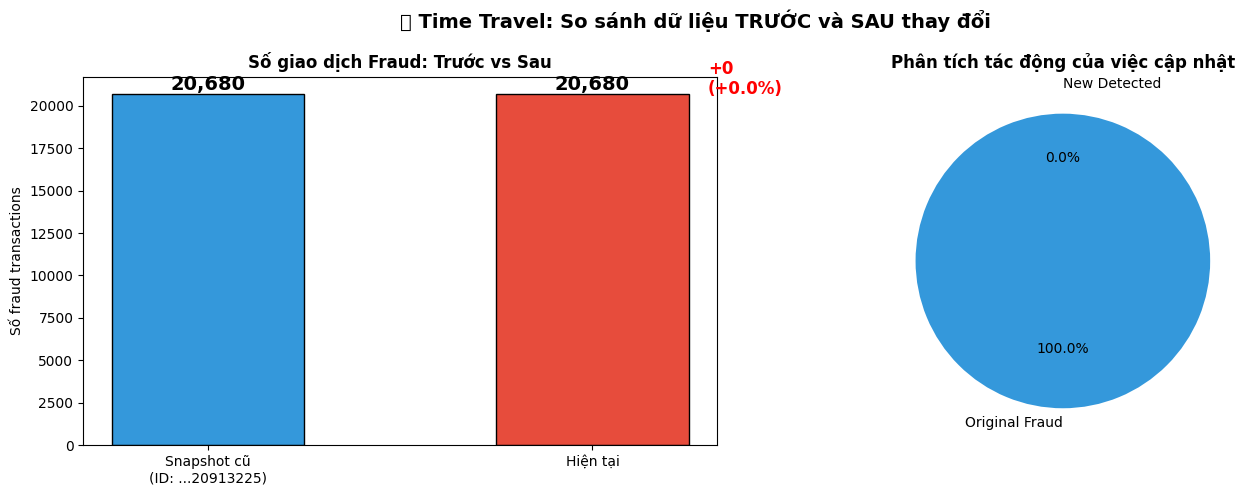

📊 Time Travel Analysis:
   - Fraud count tại snapshot cũ: 20,680
   - Fraud count hiện tại: 20,680
   - Thay đổi: +0 (0.00%)

💡 Iceberg cho phép truy vấn lại dữ liệu tại BẤT KỲ thời điểm nào trong quá khứ!


In [27]:
# 📊 VISUALIZATION: Time Travel Comparison - Before vs After
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('📊 Time Travel: So sánh dữ liệu TRƯỚC và SAU thay đổi', fontsize=14, fontweight='bold')

# Data
counts = [old_fraud_count, new_fraud_count]
labels = [f'Snapshot cũ\n(ID: ...{str(snapshot_before)[-8:]})', 'Hiện tại']
colors = ['#3498db', '#e74c3c']

# 1. Bar chart comparison
bars = axes[0].bar(labels, counts, color=colors, edgecolor='black', width=0.5)
axes[0].set_title('Số giao dịch Fraud: Trước vs Sau', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Số fraud transactions')

for bar, cnt in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 f'{cnt:,}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add change annotation
change = new_fraud_count - old_fraud_count
change_pct = (change / old_fraud_count) * 100 if old_fraud_count > 0 else 0
axes[0].annotate(f'+{change:,}\n(+{change_pct:.1f}%)', 
                 xy=(1.3, (old_fraud_count + new_fraud_count)/2),
                 fontsize=12, color='green' if change > 0 else 'red',
                 fontweight='bold')

# 2. Pie chart showing change impact
axes[1].pie([old_fraud_count, change], 
            labels=['Original Fraud', 'New Detected'],
            colors=['#3498db', '#e74c3c'],
            autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
axes[1].set_title('Phân tích tác động của việc cập nhật', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Time Travel Analysis:")
print(f"   - Fraud count tại snapshot cũ: {old_fraud_count:,}")
print(f"   - Fraud count hiện tại: {new_fraud_count:,}")
print(f"   - Thay đổi: +{change:,} ({change_pct:.2f}%)")
print("\n💡 Iceberg cho phép truy vấn lại dữ liệu tại BẤT KỲ thời điểm nào trong quá khứ!")

## 5. Use Case: Kiểm tra lại giao dịch nghi vấn tại thời điểm quá khứ

Scenario: Nhà phân tích muốn xem lại trạng thái của một số giao dịch cụ thể VÀO THỜI ĐIỂM trước khi bị đánh dấu fraud để điều tra.

In [28]:
# Lấy một số TransactionID đã bị thay đổi thành fraud
changed_transactions = spark.sql(f"""
    SELECT TransactionID 
    FROM {TABLE_NAME} 
    WHERE investigation_status = 'CONFIRMED_FRAUD'
    LIMIT 5
""").collect()

if changed_transactions:
    tx_ids = [str(row['TransactionID']) for row in changed_transactions]
    tx_list = ','.join(tx_ids)
    
    print("📋 So sánh trạng thái giao dịch TRƯỚC và SAU khi cập nhật:")
    print("=" * 80)
    
    # Trạng thái HIỆN TẠI (dùng tên cột mới từ dbt)
    print("\n🔵 TRẠNG THÁI HIỆN TẠI:")
    spark.sql(f"""
        SELECT TransactionID, is_fraud, transaction_amount, card_brand, investigation_status
        FROM {TABLE_NAME}
        WHERE TransactionID IN ({tx_list})
    """).show(truncate=False)
    
    # Trạng thái TẠI SNAPSHOT CŨ (Time Travel)
    print(f"\n🟡 TRẠNG THÁI TẠI SNAPSHOT {snapshot_before} (QUÁ KHỨ):")
    spark.sql(f"""
        SELECT TransactionID, is_fraud, transaction_amount, card_brand
        FROM {TABLE_NAME} VERSION AS OF {snapshot_before}
        WHERE TransactionID IN ({tx_list})
    """).show(truncate=False)
else:
    print("⚠️ Không có giao dịch nào được thay đổi")

📋 So sánh trạng thái giao dịch TRƯỚC và SAU khi cập nhật:

🔵 TRẠNG THÁI HIỆN TẠI:
+-------------+--------+------------------+----------+--------------------+
|TransactionID|is_fraud|transaction_amount|card_brand|investigation_status|
+-------------+--------+------------------+----------+--------------------+
|3158451      |1       |5278.95           |visa      |CONFIRMED_FRAUD     |
|3235413      |1       |6085.23           |mastercard|CONFIRMED_FRAUD     |
|3261336      |1       |31937.391         |mastercard|CONFIRMED_FRAUD     |
|3261339      |1       |31937.391         |mastercard|CONFIRMED_FRAUD     |
|3262529      |1       |5420.0            |mastercard|CONFIRMED_FRAUD     |
+-------------+--------+------------------+----------+--------------------+


🟡 TRẠNG THÁI TẠI SNAPSHOT 8157974591920913225 (QUÁ KHỨ):
+-------------+--------+------------------+----------+
|TransactionID|is_fraud|transaction_amount|card_brand|
+-------------+--------+------------------+----------+
|3158451  

## 6. Time Travel với Timestamp

Ngoài Snapshot ID, Iceberg còn hỗ trợ Time Travel theo timestamp.

In [29]:
# Lấy timestamp của snapshot đầu tiên
first_snapshot = spark.sql(f"""
    SELECT committed_at 
    FROM {TABLE_NAME}.snapshots 
    ORDER BY committed_at ASC 
    LIMIT 1
""").collect()[0][0]

print(f"📅 Timestamp của snapshot đầu tiên: {first_snapshot}")

# Time Travel theo timestamp
print("\n⏰ Time Travel theo Timestamp:")
print(f"Truy vấn dữ liệu tại thời điểm: {first_snapshot}")

# Đếm records tại thời điểm đó
count_at_time = spark.sql(f"""
    SELECT COUNT(*) 
    FROM {TABLE_NAME} 
    TIMESTAMP AS OF '{first_snapshot}'
""").collect()[0][0]

print(f"📊 Số records tại thời điểm đó: {count_at_time:,}")

📅 Timestamp của snapshot đầu tiên: 2026-02-02 17:30:44.932000

⏰ Time Travel theo Timestamp:
Truy vấn dữ liệu tại thời điểm: 2026-02-02 17:30:44.932000
📊 Số records tại thời điểm đó: 590,540


## 7. Demo Rollback (Tùy chọn)

Iceberg cho phép rollback về snapshot cũ nếu cần khôi phục dữ liệu.

**⚠️ Cảnh báo:** Rollback sẽ thay đổi dữ liệu hiện tại!

In [30]:
# Hiển thị lệnh Rollback (KHÔNG chạy tự động)
print("📋 Lệnh Rollback về snapshot cũ:")
print("=" * 60)
print(f"""
-- Rollback về snapshot cụ thể
CALL demo.system.rollback_to_snapshot('{TABLE_NAME}', {snapshot_before})

-- Hoặc rollback về timestamp
CALL demo.system.rollback_to_timestamp('{TABLE_NAME}', TIMESTAMP '{first_snapshot}')
""")

print("\n⚠️ Các lệnh trên KHÔNG được chạy tự động.")
print("   Chỉ chạy khi thực sự cần khôi phục dữ liệu.")

📋 Lệnh Rollback về snapshot cũ:

-- Rollback về snapshot cụ thể
CALL demo.system.rollback_to_snapshot('demo.bronze_silver.silver_transactions', 8157974591920913225)

-- Hoặc rollback về timestamp
CALL demo.system.rollback_to_timestamp('demo.bronze_silver.silver_transactions', TIMESTAMP '2026-02-02 17:30:44.932000')


⚠️ Các lệnh trên KHÔNG được chạy tự động.
   Chỉ chạy khi thực sự cần khôi phục dữ liệu.


## 8. Incremental Read (Đọc thay đổi giữa 2 snapshots)

Iceberg hỗ trợ đọc chỉ những thay đổi giữa 2 snapshots - hữu ích cho CDC (Change Data Capture).

In [31]:
# Lấy snapshot hiện tại
current_snapshot = spark.sql(f"""
    SELECT snapshot_id 
    FROM {TABLE_NAME}.snapshots 
    ORDER BY committed_at DESC 
    LIMIT 1
""").collect()[0][0]

print(f"📊 So sánh giữa 2 snapshots:")
print(f"   - Snapshot cũ: {snapshot_before}")
print(f"   - Snapshot mới: {current_snapshot}")

# Đọc incremental changes
try:
    df_changes = spark.read \
        .format("iceberg") \
        .option("start-snapshot-id", snapshot_before) \
        .option("end-snapshot-id", current_snapshot) \
        .load(TABLE_NAME)
    
    print(f"\n📋 Số records thay đổi: {df_changes.count():,}")
except Exception as e:
    print(f"\n⚠️ Incremental read không khả dụng: {str(e)[:100]}")
    print("   Đây là tính năng nâng cao, cần cấu hình thêm.")

📊 So sánh giữa 2 snapshots:
   - Snapshot cũ: 8157974591920913225
   - Snapshot mới: 1807761106683133715

📋 Số records thay đổi: 0


## 9. Tổng hợp các tính năng Time Travel của Iceberg

In [32]:
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    TỔNG HỢP TÍNH NĂNG TIME TRAVEL                            ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. TRUY VẤN THEO SNAPSHOT ID                                                ║
║     SELECT * FROM table VERSION AS OF <snapshot_id>                          ║
║                                                                              ║
║  2. TRUY VẤN THEO TIMESTAMP                                                  ║
║     SELECT * FROM table TIMESTAMP AS OF '<timestamp>'                        ║
║                                                                              ║
║  3. XEM LỊCH SỬ SNAPSHOTS                                                    ║
║     SELECT * FROM table.snapshots                                            ║
║     SELECT * FROM table.history                                              ║
║                                                                              ║
║  4. ROLLBACK VỀ SNAPSHOT CŨ                                                  ║
║     CALL system.rollback_to_snapshot('table', <snapshot_id>)                 ║
║     CALL system.rollback_to_timestamp('table', TIMESTAMP '<ts>')             ║
║                                                                              ║
║  5. ĐỌC INCREMENTAL CHANGES                                                  ║
║     spark.read.format("iceberg")                                             ║
║          .option("start-snapshot-id", <old>)                                 ║
║          .option("end-snapshot-id", <new>)                                   ║
║          .load("table")                                                      ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    TỔNG HỢP TÍNH NĂNG TIME TRAVEL                            ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. TRUY VẤN THEO SNAPSHOT ID                                                ║
║     SELECT * FROM table VERSION AS OF <snapshot_id>                          ║
║                                                                              ║
║  2. TRUY VẤN THEO TIMESTAMP                                                  ║
║     SELECT * FROM table TIMESTAMP AS OF '<timestamp>'                        ║
║                                                                              ║
║  3. XEM LỊCH SỬ SNAPSHOTS                                                    ║
║     SELECT * FROM table.snapshots                                            ║
║     SELECT * FROM table.h

/tmp/ipykernel_3468/360611162.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10

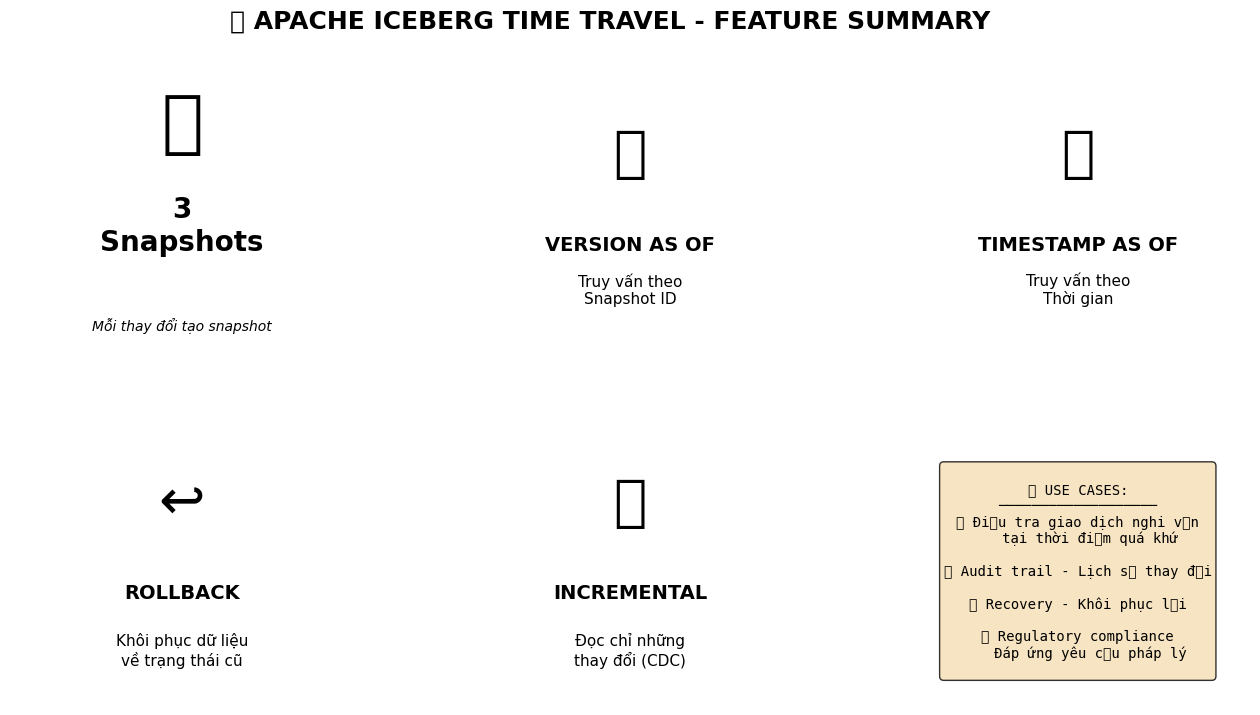

✅ Time Travel Demo hoàn tất!
   Iceberg cung cấp khả năng truy vấn dữ liệu tại MỌI thời điểm trong quá khứ!


In [33]:
# 📊 VISUALIZATION: Iceberg Time Travel Features Summary
fig = plt.figure(figsize=(16, 8))
fig.suptitle('🕰️ APACHE ICEBERG TIME TRAVEL - FEATURE SUMMARY', fontsize=18, fontweight='bold')

# Create main areas
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Snapshot Overview
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.text(5, 8, '📸', fontsize=50, ha='center')
ax1.text(5, 4, f'{len(snapshots)}\nSnapshots', fontsize=20, ha='center', fontweight='bold')
ax1.text(5, 1, 'Mỗi thay đổi tạo snapshot', fontsize=10, ha='center', style='italic')
ax1.axis('off')
ax1.set_facecolor('#ecf0f1')

# 2. Query by Snapshot ID
ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.7, '🔍', fontsize=40, ha='center', transform=ax2.transAxes)
ax2.text(0.5, 0.4, 'VERSION AS OF', fontsize=14, ha='center', fontweight='bold', transform=ax2.transAxes)
ax2.text(0.5, 0.2, 'Truy vấn theo\nSnapshot ID', fontsize=11, ha='center', transform=ax2.transAxes)
ax2.axis('off')

# 3. Query by Timestamp
ax3 = fig.add_subplot(gs[0, 2])
ax3.text(0.5, 0.7, '⏰', fontsize=40, ha='center', transform=ax3.transAxes)
ax3.text(0.5, 0.4, 'TIMESTAMP AS OF', fontsize=14, ha='center', fontweight='bold', transform=ax3.transAxes)
ax3.text(0.5, 0.2, 'Truy vấn theo\nThời gian', fontsize=11, ha='center', transform=ax3.transAxes)
ax3.axis('off')

# 4. Rollback capability
ax4 = fig.add_subplot(gs[1, 0])
ax4.text(0.5, 0.7, '↩️', fontsize=40, ha='center', transform=ax4.transAxes)
ax4.text(0.5, 0.4, 'ROLLBACK', fontsize=14, ha='center', fontweight='bold', transform=ax4.transAxes)
ax4.text(0.5, 0.15, 'Khôi phục dữ liệu\nvề trạng thái cũ', fontsize=11, ha='center', transform=ax4.transAxes)
ax4.axis('off')

# 5. Incremental Read
ax5 = fig.add_subplot(gs[1, 1])
ax5.text(0.5, 0.7, '📈', fontsize=40, ha='center', transform=ax5.transAxes)
ax5.text(0.5, 0.4, 'INCREMENTAL', fontsize=14, ha='center', fontweight='bold', transform=ax5.transAxes)
ax5.text(0.5, 0.15, 'Đọc chỉ những\nthay đổi (CDC)', fontsize=11, ha='center', transform=ax5.transAxes)
ax5.axis('off')

# 6. Use Case for Fraud Detection
ax6 = fig.add_subplot(gs[1, 2])
use_cases = """
💼 USE CASES:
───────────────────
✅ Điều tra giao dịch nghi vấn
   tại thời điểm quá khứ

✅ Audit trail - Lịch sử thay đổi

✅ Recovery - Khôi phục lỗi

✅ Regulatory compliance
   Đáp ứng yêu cầu pháp lý
"""
ax6.text(0.5, 0.5, use_cases, fontsize=10, ha='center', va='center', 
         transform=ax6.transAxes, fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax6.axis('off')

plt.tight_layout()
plt.show()

print("✅ Time Travel Demo hoàn tất!")
print("   Iceberg cung cấp khả năng truy vấn dữ liệu tại MỌI thời điểm trong quá khứ!")

## ✅ Hoàn thành Time Travel Demo

**Kết quả đã demo:**
- ✅ Xem lịch sử Snapshots và History
- ✅ Time Travel theo Snapshot ID
- ✅ Time Travel theo Timestamp
- ✅ So sánh dữ liệu giữa các thời điểm
- ✅ Use case: Kiểm tra lại giao dịch nghi vấn tại quá khứ
- ✅ Giới thiệu Rollback và Incremental Read

**Ứng dụng trong Fraud Detection:**
- Điều tra lại trạng thái giao dịch tại thời điểm nghi vấn
- Audit trail: Xem lịch sử thay đổi của dữ liệu
- Recovery: Khôi phục dữ liệu nếu có lỗi
- Regulatory compliance: Đáp ứng yêu cầu lưu trữ lịch sử

---
## 🎉 HOÀN THÀNH TOÀN BỘ QUY TRÌNH LAKEHOUSE!

| Bước | Nội dung | Trạng thái |
|------|----------|------------|
| 1 | Thiết lập hạ tầng (Docker) | ✅ |
| 2 | Bronze Layer (Ingestion) | ✅ |
| 3 | Silver Layer (Transformation) | ✅ |
| 4 | Gold Layer (Aggregation) | ✅ |
| 5 | Serving Layer (ClickHouse + Superset) | ✅ |
| Bonus | Time Travel Demo | ✅ |